In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/nft/'
os.listdir(base_dir)

['txn_history-2021-10-07.jsonl',
 'cryptopunks_generator.pth',
 'imgs',
 'nft_generated.jpg',
 'decoder576final_punk.h5',
 'encoder5_punk.h5',
 'NFT_creation.ipynb']

In [ ]:
data_dir = '/content/drive/MyDrive/nft/txn_history-2021-10-07.jsonl'
image_dir = "/content/drive/MyDrive/nft/imgs/imgs"
image_root = "/content/drive/MyDrive/nft/imgs"

In [ ]:
df = pd.read_json(base_dir + 'txn_history-2021-10-07.jsonl', lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


Sample 100 CryptoPunks


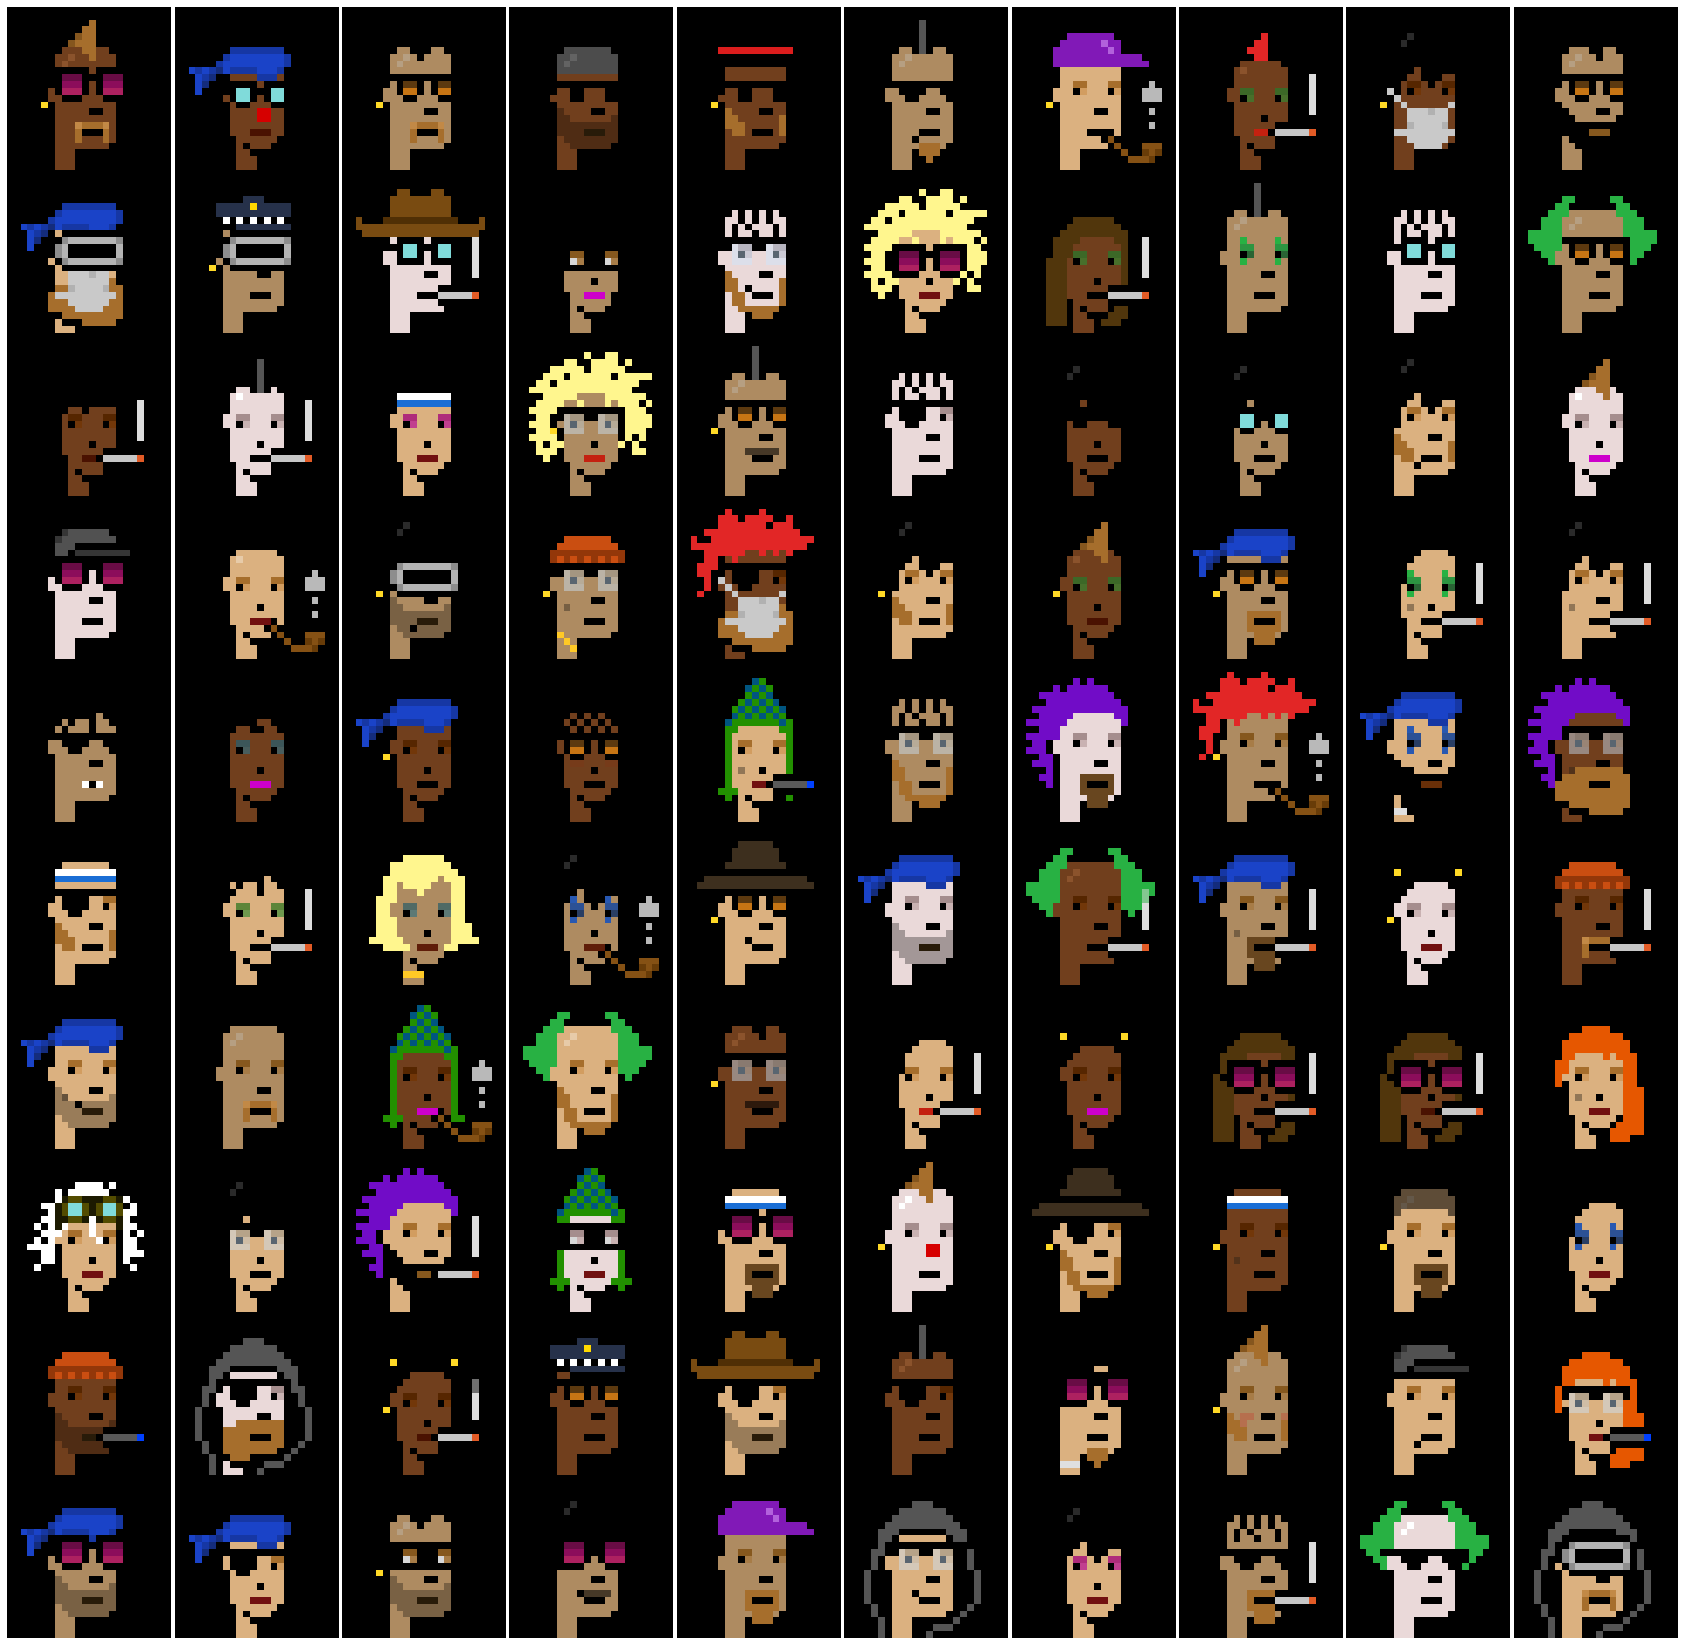

In [ ]:

no_plots = 10*10


images = glob.glob("/content/drive/MyDrive/nft/imgs/imgs/*.png")

plt.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample 100 CryptoPunks")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) 
plt.show()

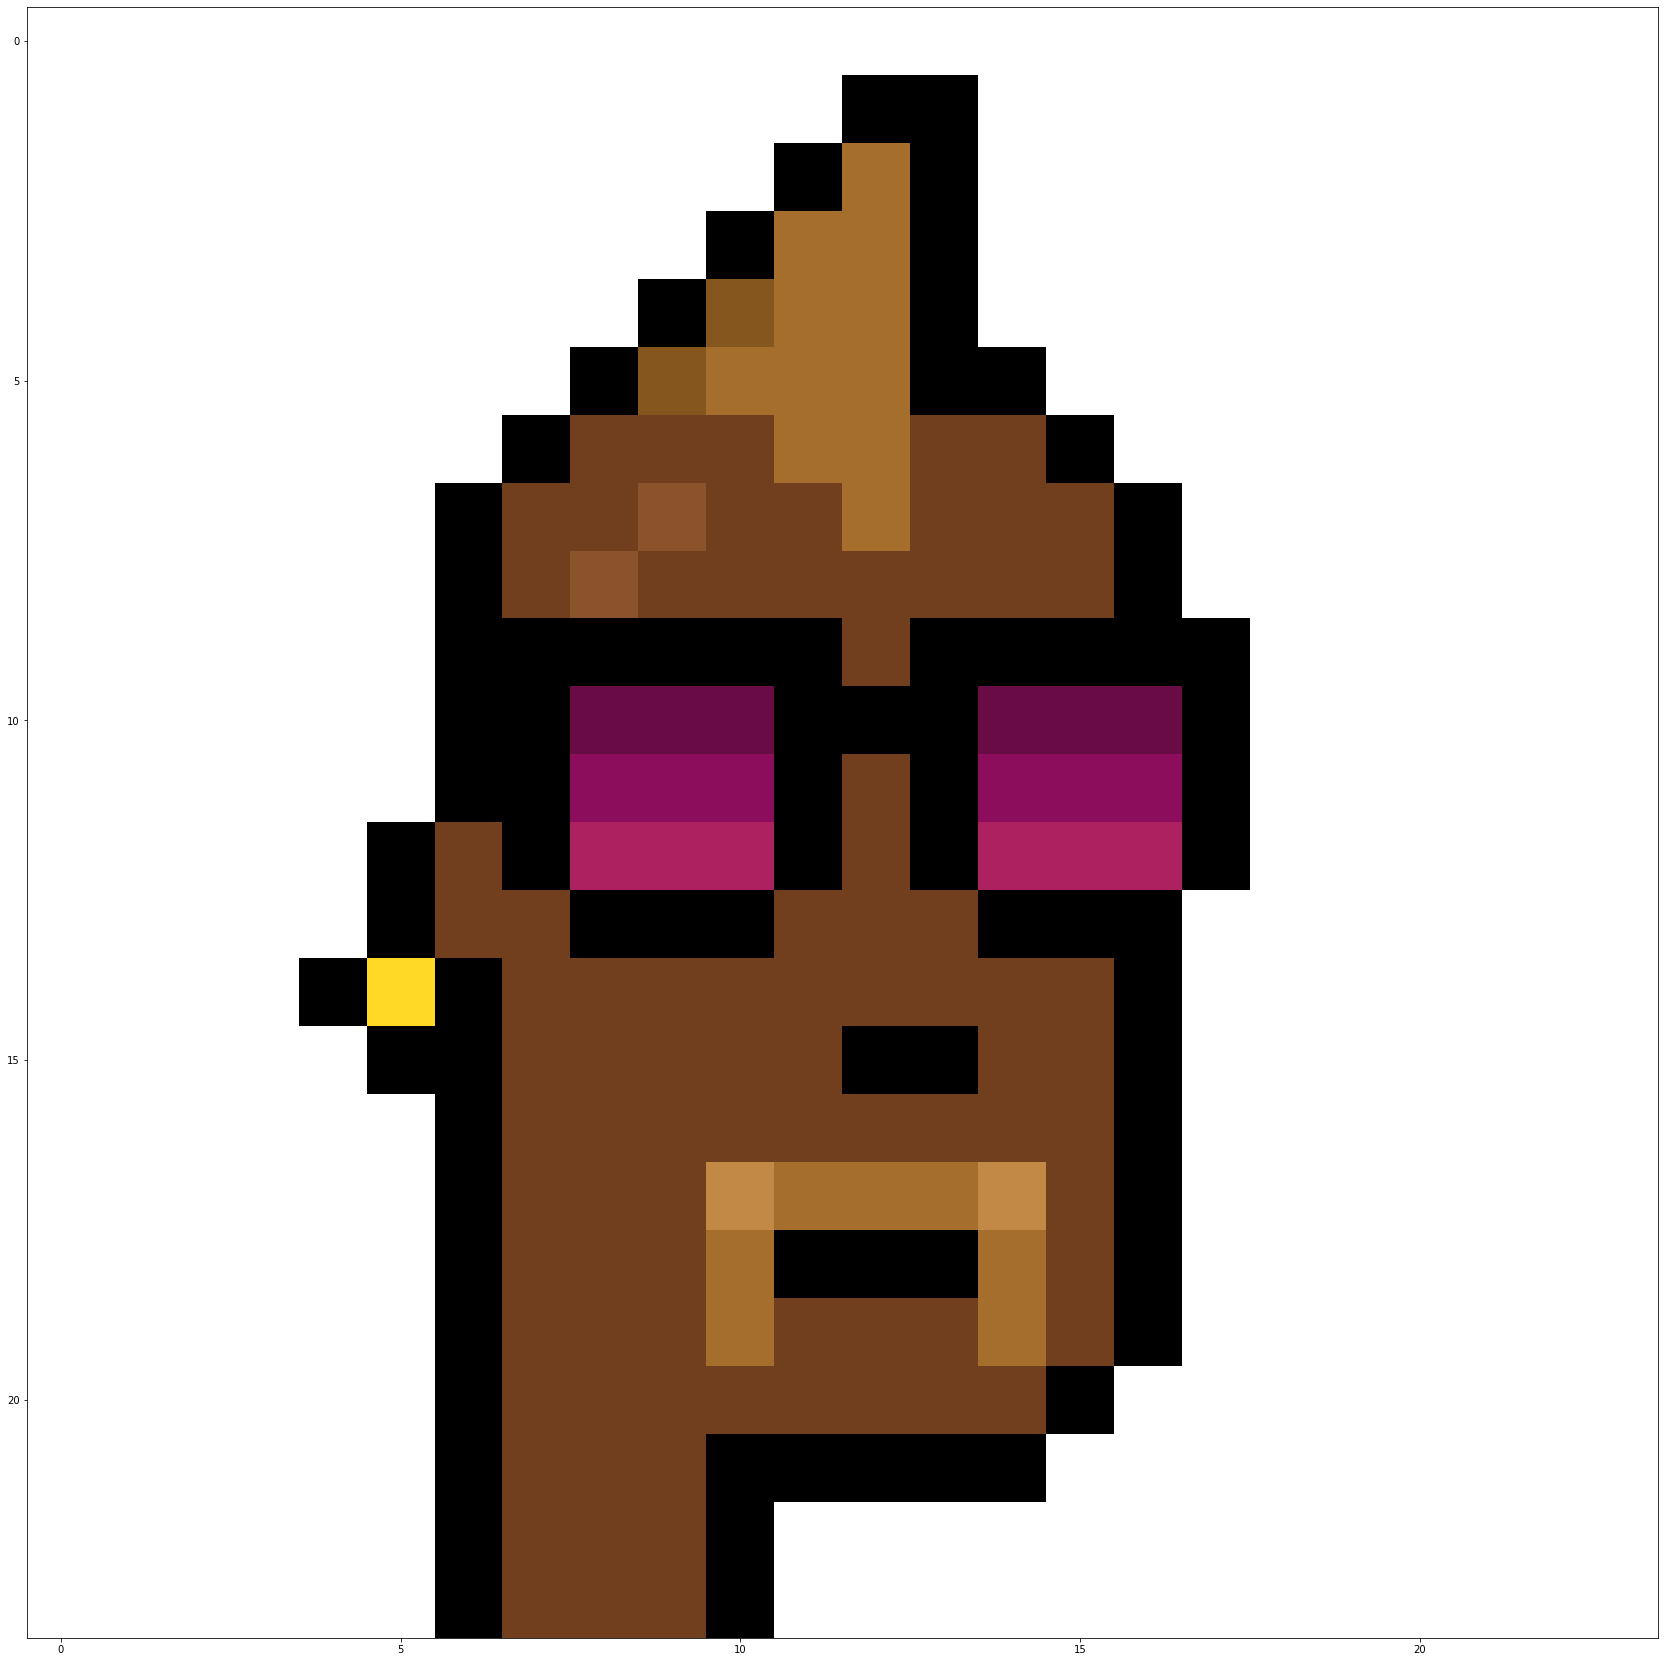

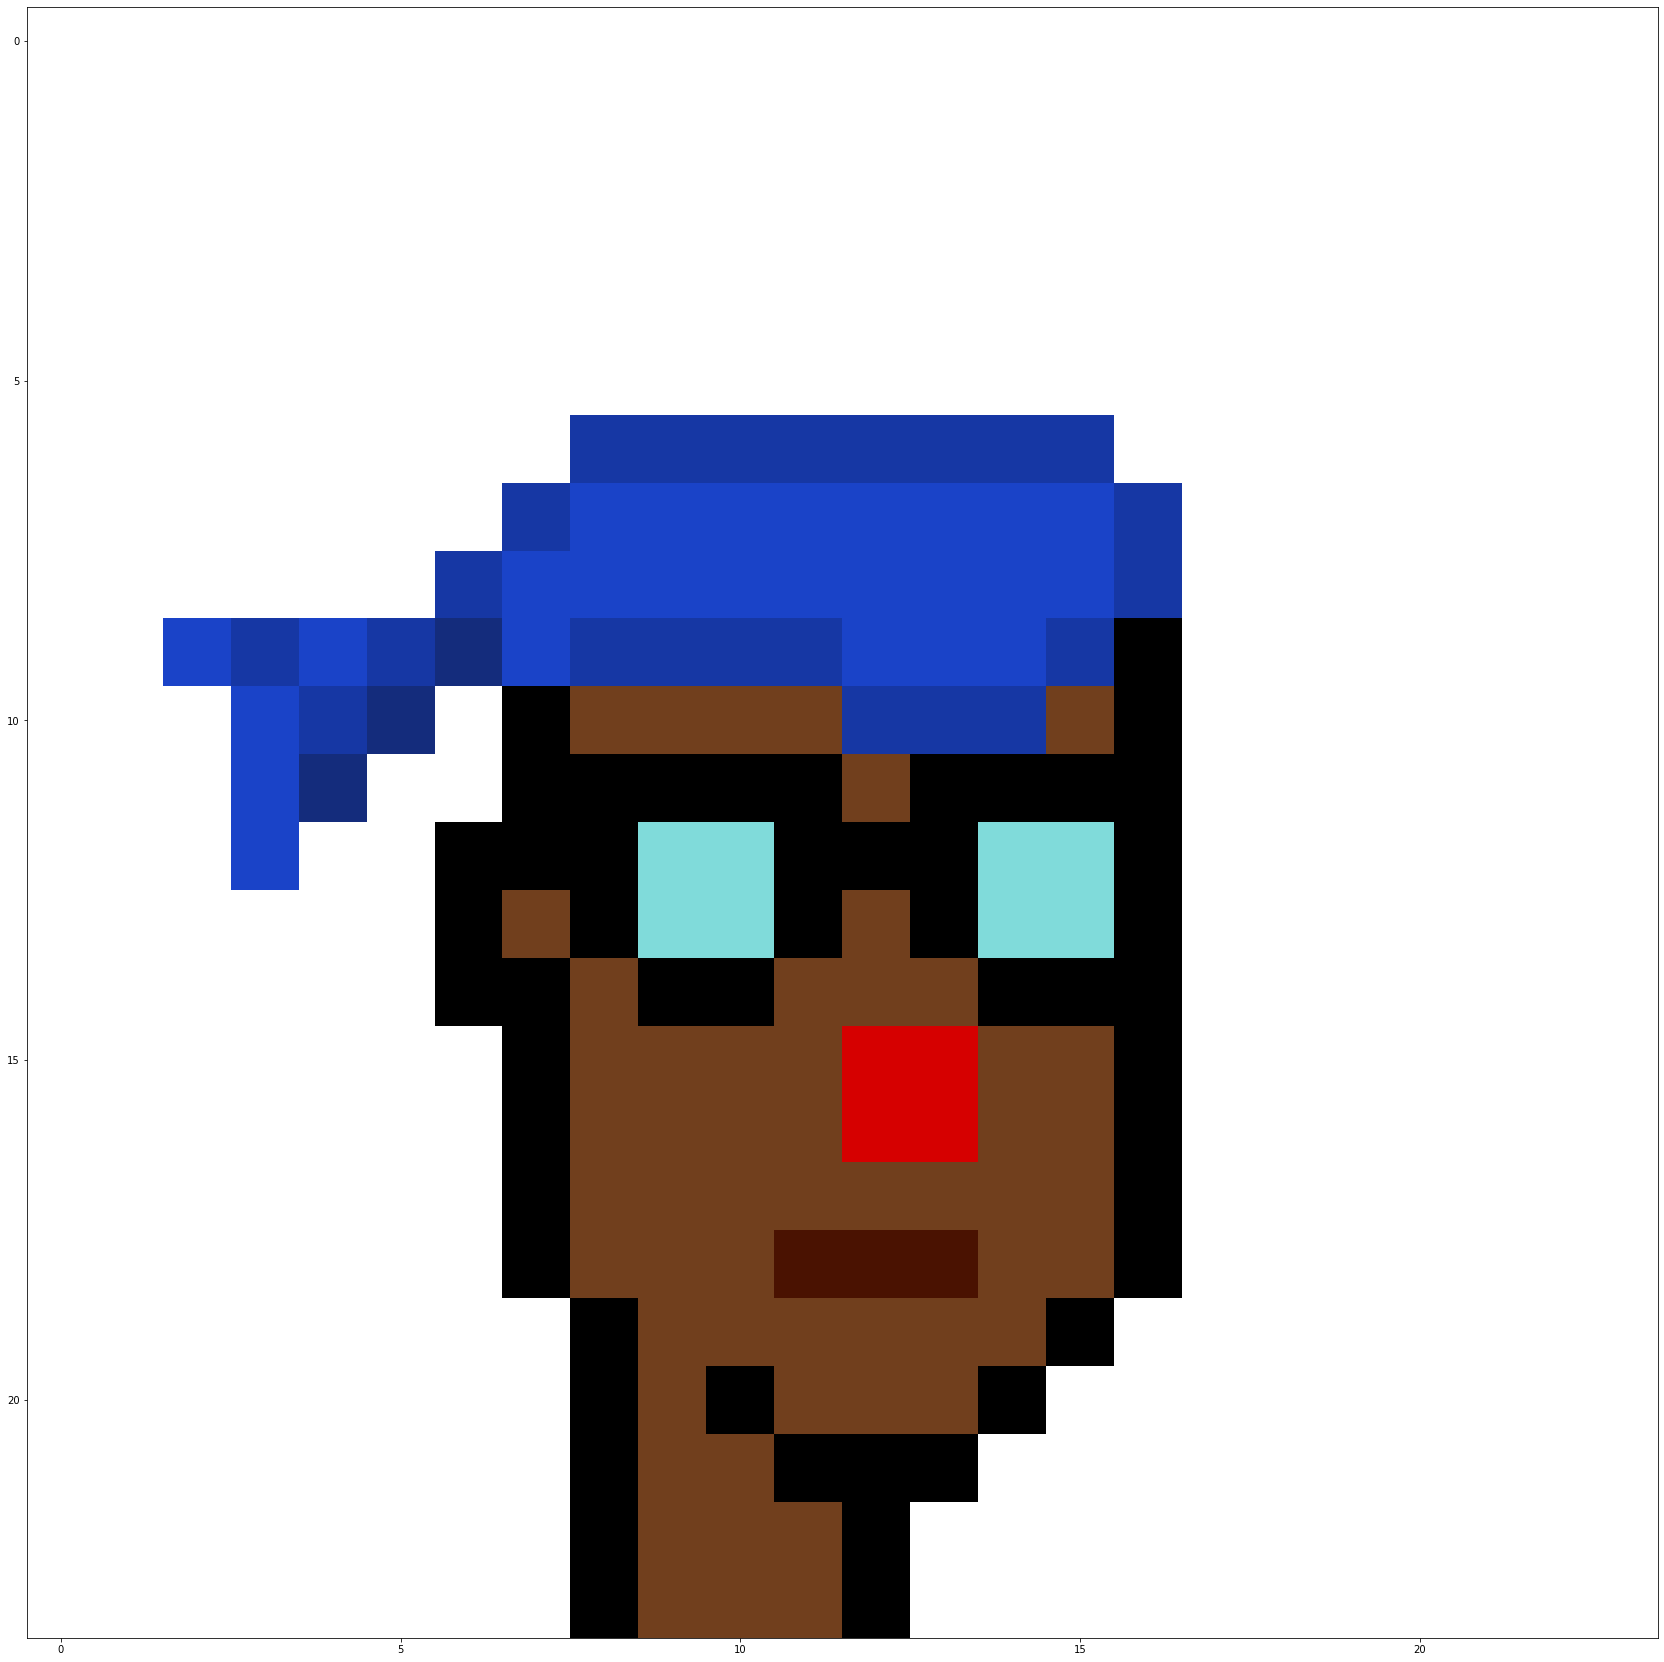

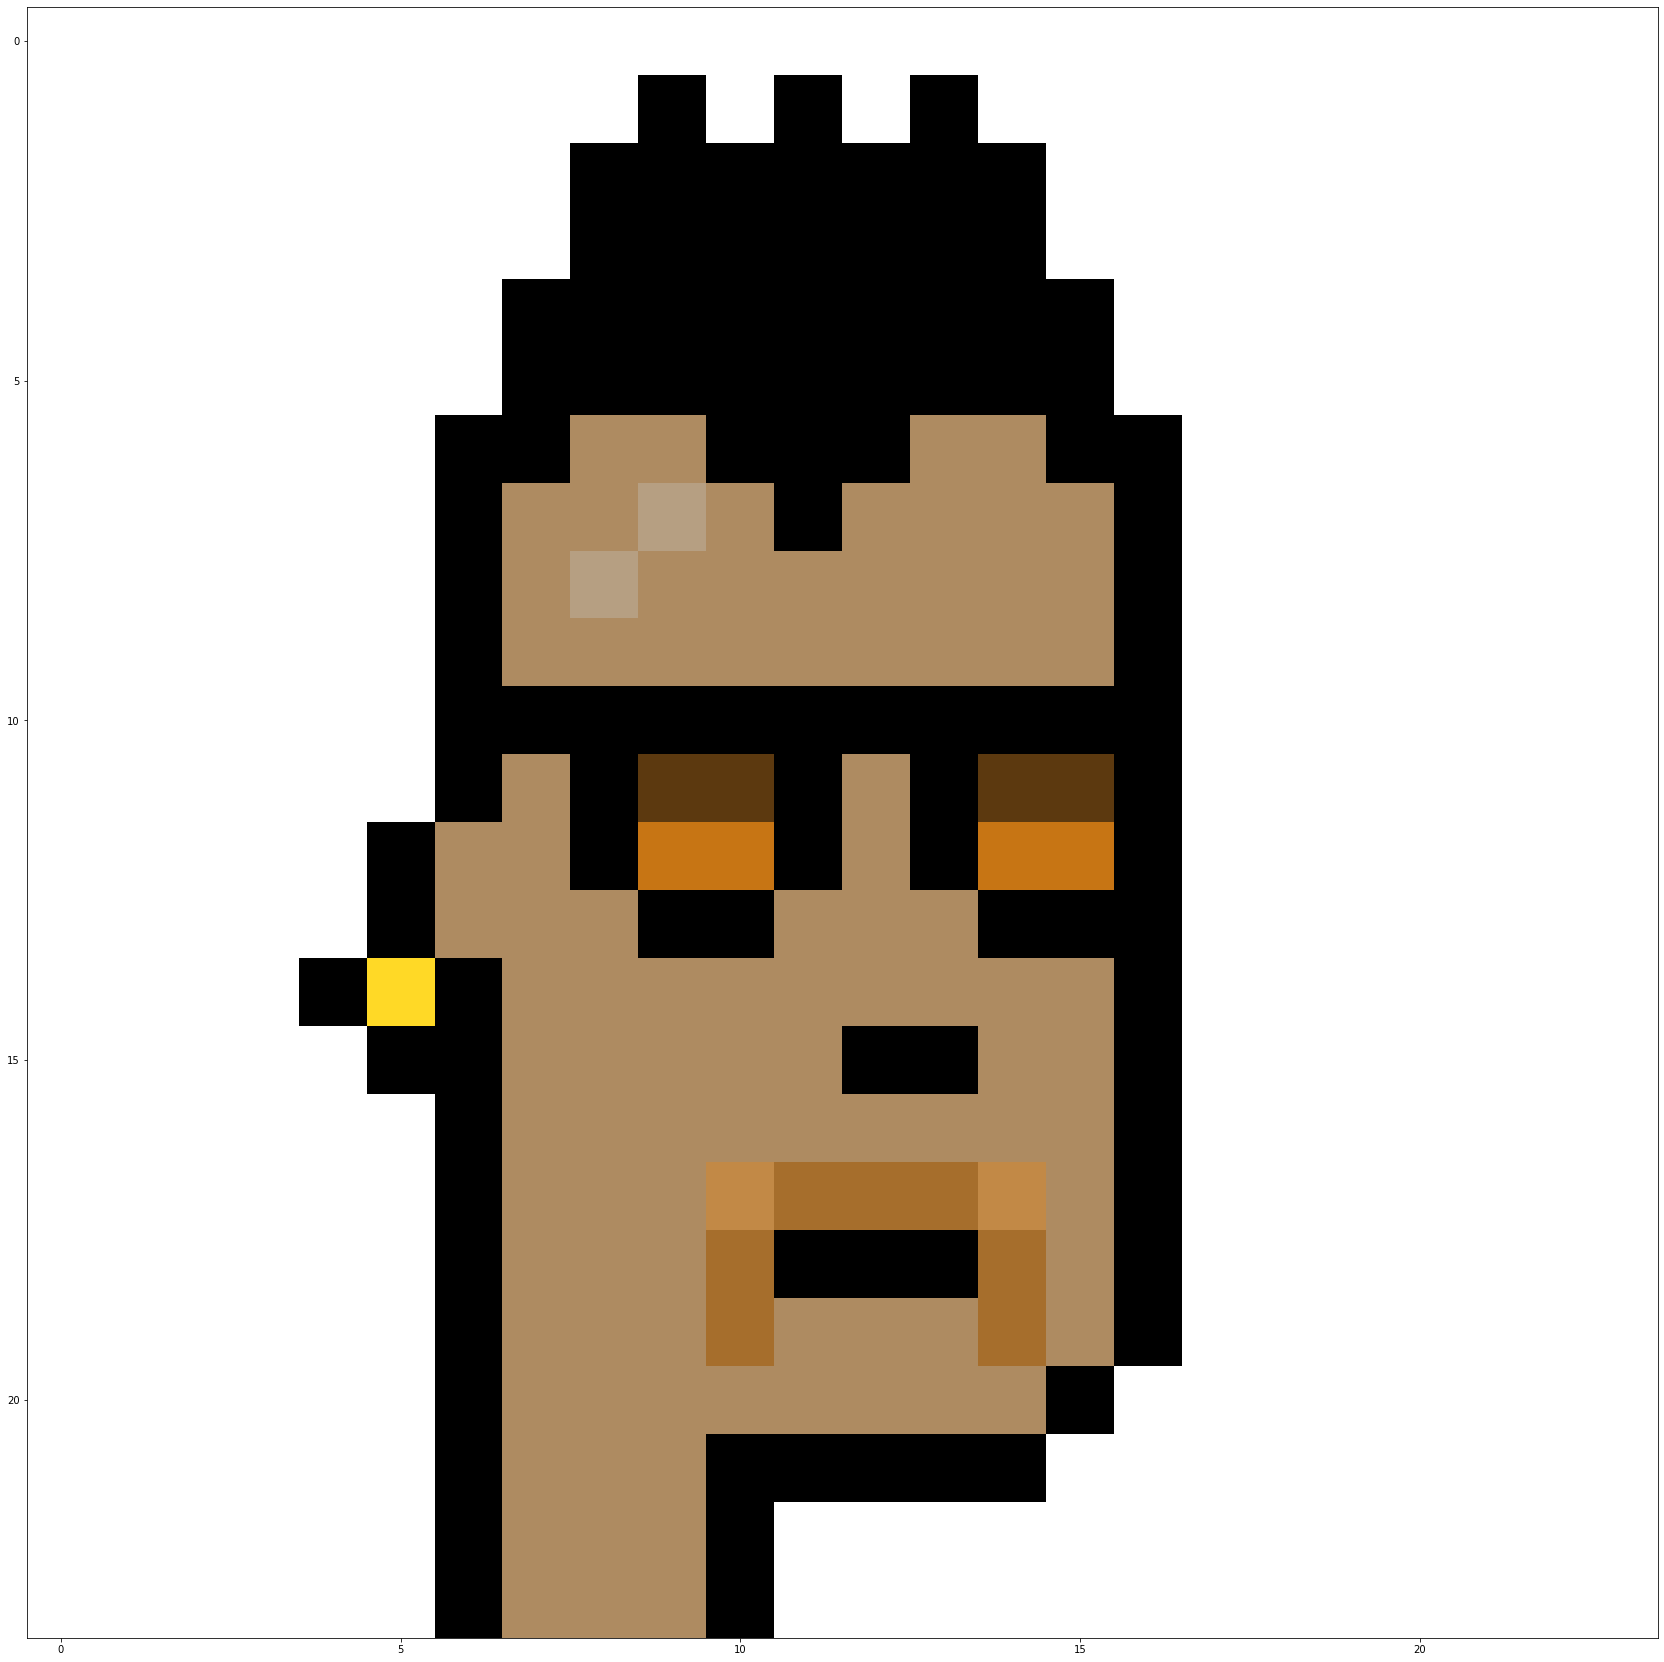

In [ ]:
punks = [img for img in glob.glob("/content/drive/MyDrive/nft/imgs/imgs/*.png")]

for punk in punks[0:3]:
    img = plt.imread(punk)
    plt.imshow(img)
    plt.show()

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

In [ ]:

df = df[["txn_type", "date", "eth", "punk_id", "type", "accessories"]]
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [ ]:

df = df.explode("type")
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"


In [ ]:
#visualize
fig = px.bar(df[df.txn_type == 'Sold'].groupby("type").agg({"eth": "max"}).sort_values(by="eth").reset_index('type'),
             x="type", 
             y="eth", 
             color="type", 
             title="CryptoPunk Types vs. Price")
fig.show()

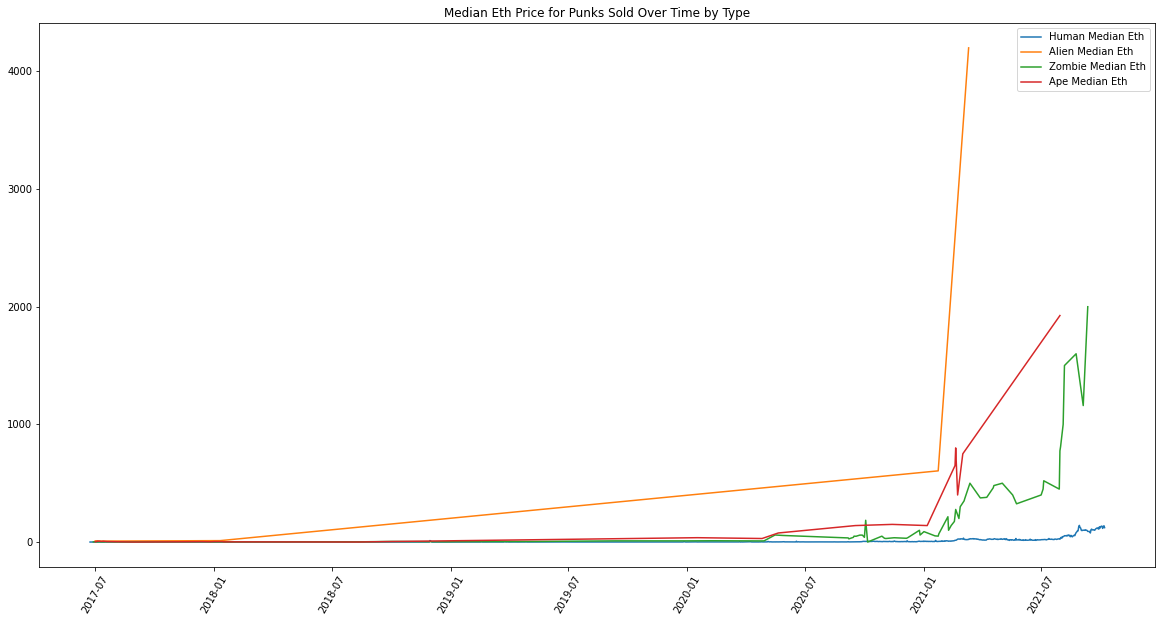

In [ ]:
#visualize human
human = df[(df.txn_type == 'Sold') & ((df.type == "Female") | (df.type == "Male")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize alien
alien = df[(df.txn_type == 'Sold') & ((df.type == "Alien")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize zombie
zombie = df[(df.txn_type == 'Sold') & ((df.type == "Zombie")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize ape
ape = df[(df.txn_type == 'Sold') & ((df.type == "Ape")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

plt.figure(figsize=(20,10))
plt.plot(human['date'], 
         human['eth']['median'], 
         label="Human Median Eth")

plt.plot(alien['date'], 
         alien['eth']['median'], 
         label="Alien Median Eth")

plt.plot(zombie['date'], 
         zombie['eth']['median'], 
         label="Zombie Median Eth")

plt.plot(ape['date'], 
         ape['eth']['median'], 
         label="Ape Median Eth")

plt.legend()
plt.xticks(rotation=60)
plt.title("Median Eth Price for Punks Sold Over Time by Type")
plt.show()

In [ ]:
#get number of attributes
df['num_attributes'] = df.accessories.apply(lambda x: len(x))

In [ ]:
#visualize number of attributes vs price for alien
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Alien"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", 
             y="eth", 
             color="eth", 
             title="CryptoPunk Price per Number of Attributes of Alien Punks")
fig.show()

In [ ]:

fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Zombie"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", 
             y="eth", 
             color="eth", 
             title="CryptoPunk Price per Number of Attributes of Zombie Punks")
fig.show()

In [ ]:
#visualize number of attributes vs price for ape
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Ape"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", 
             y="eth", 
             color="eth", 
             title="CryptoPunk Price per Number of Attributes of Ape Punks")
fig.show()

In [ ]:
#display tensor image
def tensor_imshow(img, dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def get_dataloader(batch_size,           
                   image_size,           
                   data_dir=image_dir,   
                   num_workers=3):       
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
    
   
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  #resize
                                    transforms.ToTensor(),                        #convert to tensor
                                    transforms.Normalize(*stats)])                #normalize to be between -1 and 1
    
    
    dataset = datasets.ImageFolder(root=data_dir,
                                   transform=transform)
    
   
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True)
    
    return data_loader

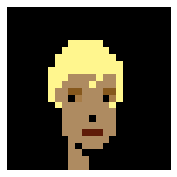

In [ ]:
#test dataloader
batch_size, image_size = 5, 24

train_loader = get_dataloader(batch_size,
                              image_size,
                              image_root)

dataiter = iter(train_loader) 

img,_ = next(dataiter)
sample_img = img[-1]

#display tensor image
tensor_imshow(sample_img)

In [ ]:
class Generator(nn.Module):       #signals neural network
    def __init__(self, 
                 z_dim=100,      #noise vector
                 im_chan=3,      #color chanel, 3 for red green blue
                 hidden_dim=64): #spatial size of feature map (conv)
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        
        self.generator_cnn = nn.Sequential(self.make_gen_block(z_dim, hidden_dim*8, stride=1, padding=0),   
                                           #(64*8) x 4 x 4
                                           self.make_gen_block(hidden_dim*8, hidden_dim*4),                           
                                           #(64*4) x 8 x 8
                                           self.make_gen_block(hidden_dim*4, hidden_dim*2),                           
                                           #(64*2) x 16 x 16
                                           self.make_gen_block(hidden_dim*2, hidden_dim),                             
                                           #(64) x 32 x 32
                                           self.make_gen_block(hidden_dim, im_chan, final_layer=True))
    
    def make_gen_block(self, 
                       im_chan,     #image dimension
                       op_chan,     #output dimension
                       kernel_size=4, 
                       stride=2, 
                       padding=1, 
                       final_layer=False): 
        
        layers = []
        #de-convolutional layer
        layers.append(nn.ConvTranspose2d(im_chan,     
                                         op_chan, 
                                         kernel_size, 
                                         stride, 
                                         padding, 
                                         bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator_cnn(x)

    def get_noise(n_samples, 
                  z_dim, 
                  device='cpu'):
        return torch.randn(n_samples, 
                           z_dim, 
                           device=device)

In [ ]:
#test Generator
noise = Generator.get_noise(n_samples=5,
                            z_dim=100)

g = Generator(z_dim=100,
              im_chan=3,
              hidden_dim=64)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, 
                 im_chan=3,       #image channels, 3 for red green blue
                 conv_dim=64,     #spatial dimension of feature map
                 image_size=64):  #spatial size of training images
        
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(self.make_disc_block(im_chan, conv_dim),
                                      self.make_disc_block(conv_dim, conv_dim*2),
                                      self.make_disc_block(conv_dim*2, conv_dim*4),
                                      self.make_disc_block(conv_dim*4, conv_dim*8),
                                      #no need a sigmoid here since it is included in the loss function
                                      self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True)) 
        
        
    def make_disc_block(self,
                        im_chan,
                        op_chan,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        final_layer=False):
        layers = []
        layers.append(nn.Conv2d(im_chan,
                                op_chan,
                                kernel_size,
                                stride,
                                padding,
                                bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
   
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [ ]:
#test Discriminator
d = Discriminator(im_chan=3,
                  conv_dim=64,
                  image_size=64)

In [ ]:

def weights_init_normal(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) 
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
def real_loss(D_out,device='cpu'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    batch_size = D_out.size(0)
    
    #labels will be used when calculating the losses
    #real labels = 1 and lable smoothing => 0.9
    labels = torch.ones(batch_size, device=device)*0.9 
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def fake_loss(D_out, device='cpu'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    batch_size = D_out.size(0)
    
    #labels will be used when calculating the losses
    #fake labels = 0
    labels = torch.zeros(batch_size,
                         device=device) 
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def print_tensor_images(images_tensor):
    
    '''
    Function for visualizing images: Given a tensor of images, prints the images.
    '''
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

In [ ]:
def train(D, G, 
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          print_every=50,
          device='cpu'):
    
    
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,
                                  z_dim=z_dim,
                                  device=device)
    
    for epoch in range(1,n_epochs+1):
        #use dataloader to fetch batches
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
           
            d_optimizer.zero_grad()
            
           
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,
                                    device=device)
            
            #train with all-fake batch
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            fake_images = G(noise)
            
           
            d_fake_op = D(fake_images) 
            d_fake_loss = fake_loss(d_fake_op,
                                    device=device)
            
            #total loss
            d_loss = d_real_loss + d_fake_loss
            
           
            d_loss.backward()
            #update optimizer
            d_optimizer.step()
            
           
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            
            
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out, 
                               device=device) 
            #update gradients
            g_loss.backward()
            #update optimizer
            g_optimizer.step()
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch, 
                                                                               n_epochs, 
                                                                               d_loss.item(),  
                                                                               g_loss.item())) 
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

In [ ]:
#hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ", device)


z_dim = 100       #noise
beta_1 = 0.5      #as specified in the original DCGAN paper
beta_2 = 0.999 
lr = 0.0002       #as specified in the original DCGAN paper
n_epochs = 100
batch_size = 128
image_size = 64

Device is  cuda


In [ ]:
#initialize generator
generator = Generator(z_dim, 
                      im_chan=3, 
                      hidden_dim=64).to(device)

#initialize discriminator
discriminator = Discriminator(im_chan=3, 
                              conv_dim=64, 
                              image_size=image_size).to(device)

#setup Adam optimizers for generator
g_optimizer = optim.Adam(generator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup Adam optimizers for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup dataloader
dataloader = get_dataloader(batch_size, 
                            image_size, 
                            image_root)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Epoch [    1/  100] | d_loss: 0.3438 | g_loss: 6.1294
Epoch [    2/  100] | d_loss: 0.4084 | g_loss: 3.6124
Epoch [    3/  100] | d_loss: 0.5423 | g_loss: 3.1156
Epoch [    4/  100] | d_loss: 0.4971 | g_loss: 2.1891
Epoch [    5/  100] | d_loss: 0.8966 | g_loss: 4.5733
Epoch [    6/  100] | d_loss: 0.4709 | g_loss: 2.9072
Epoch [    7/  100] | d_loss: 0.4852 | g_loss: 3.3588
Epoch [    8/  100] | d_loss: 0.4499 | g_loss: 2.5605
Epoch [    9/  100] | d_loss: 0.6657 | g_loss: 2.4033
Epoch [   10/  100] | d_loss: 0.3627 | g_loss: 5.6282


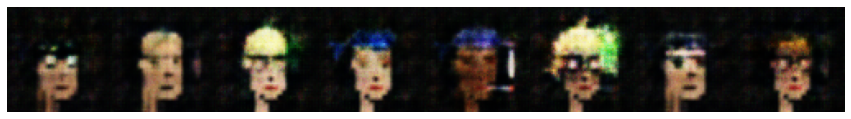

Epoch [   11/  100] | d_loss: 1.1619 | g_loss: 5.4074
Epoch [   12/  100] | d_loss: 0.4833 | g_loss: 3.2665
Epoch [   13/  100] | d_loss: 0.4252 | g_loss: 3.6020
Epoch [   14/  100] | d_loss: 0.5050 | g_loss: 2.8992
Epoch [   15/  100] | d_loss: 0.3645 | g_loss: 4.8972
Epoch [   16/  100] | d_loss: 0.5007 | g_loss: 4.9296
Epoch [   17/  100] | d_loss: 1.0341 | g_loss: 0.8854
Epoch [   18/  100] | d_loss: 0.3735 | g_loss: 3.9359
Epoch [   19/  100] | d_loss: 0.3720 | g_loss: 4.1202
Epoch [   20/  100] | d_loss: 0.3381 | g_loss: 5.0804


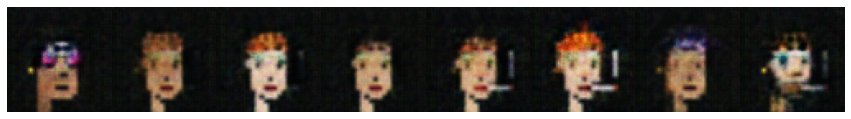

Epoch [   21/  100] | d_loss: 0.5869 | g_loss: 1.6709
Epoch [   22/  100] | d_loss: 0.4448 | g_loss: 4.9473
Epoch [   23/  100] | d_loss: 0.3639 | g_loss: 5.5918
Epoch [   24/  100] | d_loss: 0.4186 | g_loss: 5.7404
Epoch [   25/  100] | d_loss: 0.5237 | g_loss: 2.4503
Epoch [   26/  100] | d_loss: 0.4518 | g_loss: 3.8028
Epoch [   27/  100] | d_loss: 0.4270 | g_loss: 4.4215
Epoch [   28/  100] | d_loss: 0.3660 | g_loss: 4.7649
Epoch [   29/  100] | d_loss: 0.4686 | g_loss: 1.8041
Epoch [   30/  100] | d_loss: 0.3410 | g_loss: 5.7060


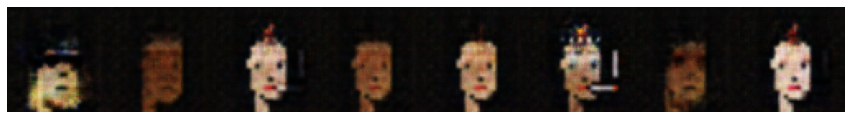

Epoch [   31/  100] | d_loss: 2.2245 | g_loss: 0.4799
Epoch [   32/  100] | d_loss: 0.3724 | g_loss: 4.2321
Epoch [   33/  100] | d_loss: 0.6541 | g_loss: 0.5550
Epoch [   34/  100] | d_loss: 0.4024 | g_loss: 6.3338
Epoch [   35/  100] | d_loss: 0.3605 | g_loss: 2.8656
Epoch [   36/  100] | d_loss: 0.3308 | g_loss: 5.9636
Epoch [   37/  100] | d_loss: 0.3326 | g_loss: 4.9800
Epoch [   38/  100] | d_loss: 0.3512 | g_loss: 6.4820
Epoch [   39/  100] | d_loss: 0.4051 | g_loss: 4.6212
Epoch [   40/  100] | d_loss: 0.3418 | g_loss: 7.1398


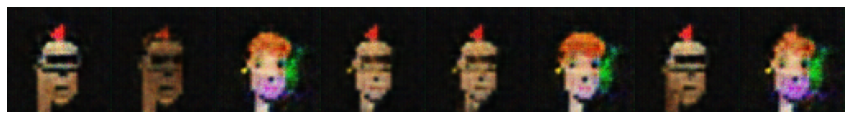

Epoch [   41/  100] | d_loss: 0.4904 | g_loss: 1.9846
Epoch [   42/  100] | d_loss: 0.3846 | g_loss: 7.1234
Epoch [   43/  100] | d_loss: 0.3562 | g_loss: 4.8774
Epoch [   44/  100] | d_loss: 0.9587 | g_loss: 1.0048
Epoch [   45/  100] | d_loss: 3.1563 | g_loss: 0.4863
Epoch [   46/  100] | d_loss: 0.4015 | g_loss: 2.7784
Epoch [   47/  100] | d_loss: 0.3724 | g_loss: 5.1820
Epoch [   48/  100] | d_loss: 0.4240 | g_loss: 2.8674
Epoch [   49/  100] | d_loss: 0.6756 | g_loss: 1.3613
Epoch [   50/  100] | d_loss: 1.3151 | g_loss: 0.8479


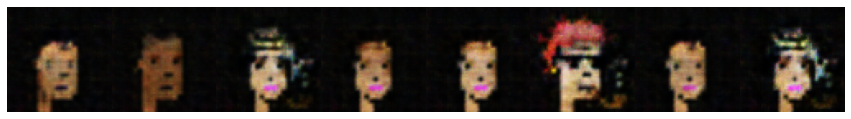

Epoch [   51/  100] | d_loss: 0.3993 | g_loss: 1.7822
Epoch [   52/  100] | d_loss: 0.3332 | g_loss: 6.6608
Epoch [   53/  100] | d_loss: 0.3748 | g_loss: 3.3291
Epoch [   54/  100] | d_loss: 0.3589 | g_loss: 6.2124
Epoch [   55/  100] | d_loss: 0.6376 | g_loss: 4.8179
Epoch [   56/  100] | d_loss: 1.4830 | g_loss: 0.3978
Epoch [   57/  100] | d_loss: 0.5961 | g_loss: 0.9560
Epoch [   58/  100] | d_loss: 0.5576 | g_loss: 2.4345
Epoch [   59/  100] | d_loss: 0.4214 | g_loss: 7.3855
Epoch [   60/  100] | d_loss: 0.3442 | g_loss: 4.2660


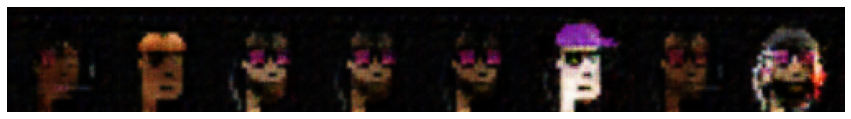

Epoch [   61/  100] | d_loss: 0.4156 | g_loss: 3.3699
Epoch [   62/  100] | d_loss: 0.4431 | g_loss: 5.2109
Epoch [   63/  100] | d_loss: 0.4696 | g_loss: 3.5802
Epoch [   64/  100] | d_loss: 2.0762 | g_loss: 1.5534
Epoch [   65/  100] | d_loss: 0.3555 | g_loss: 5.5331
Epoch [   66/  100] | d_loss: 0.9093 | g_loss: 0.6672
Epoch [   67/  100] | d_loss: 0.3993 | g_loss: 3.5218
Epoch [   68/  100] | d_loss: 0.3592 | g_loss: 3.2764
Epoch [   69/  100] | d_loss: 0.5679 | g_loss: 1.6608
Epoch [   70/  100] | d_loss: 0.3511 | g_loss: 5.5506


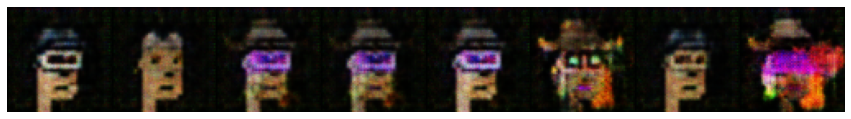

Epoch [   71/  100] | d_loss: 0.4140 | g_loss: 3.4309
Epoch [   72/  100] | d_loss: 0.4069 | g_loss: 3.5925
Epoch [   73/  100] | d_loss: 0.8842 | g_loss: 3.8612
Epoch [   74/  100] | d_loss: 0.3615 | g_loss: 5.0072
Epoch [   75/  100] | d_loss: 0.6174 | g_loss: 1.6217
Epoch [   76/  100] | d_loss: 0.4487 | g_loss: 4.0034
Epoch [   77/  100] | d_loss: 0.3683 | g_loss: 6.3708
Epoch [   78/  100] | d_loss: 1.5996 | g_loss: 0.8848
Epoch [   79/  100] | d_loss: 0.5099 | g_loss: 1.8754
Epoch [   80/  100] | d_loss: 0.3768 | g_loss: 5.6790


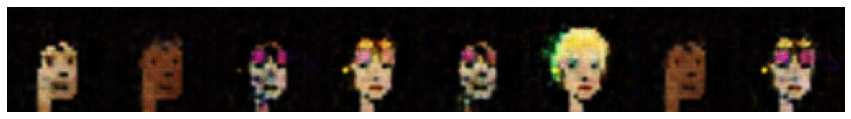

In [ ]:
#start training
%time
n_epochs = 100
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=10,
      device=device)

In [ ]:
plt.figure(figsize = (15, 8))
plt.plot(noise)
plt.title("Noise")
plt.show()

In [ ]:
#def save_model(generator,file_name):
#    generator = generator.to('cuda')
#    torch.save(generator.state_dict(),"cryptopunks_generator.pth")
#
#save_model(generator,"kaggle")

In [ ]:
device = torch.device('cpu')
generator = Generator()
generator.load_state_dict(torch.load('/content/drive/MyDrive/nft/cryptopunks_generator.pth',map_location=device))

<All keys matched successfully>

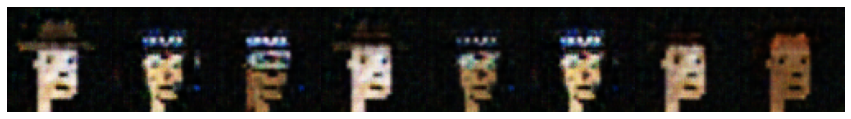

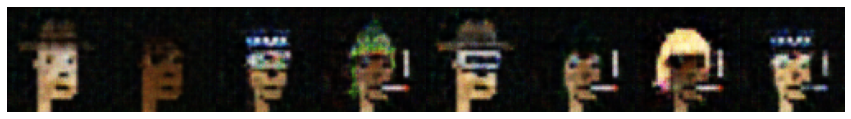

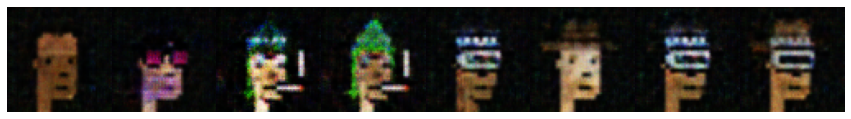

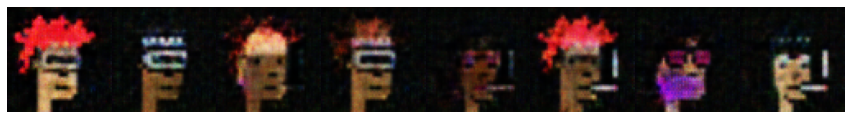

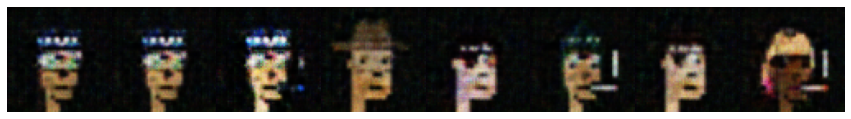

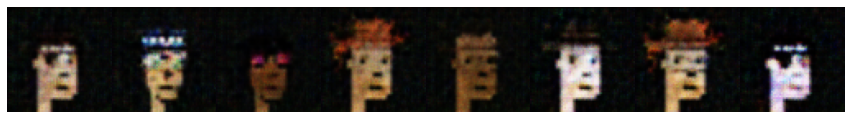

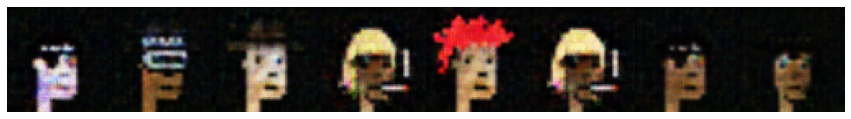

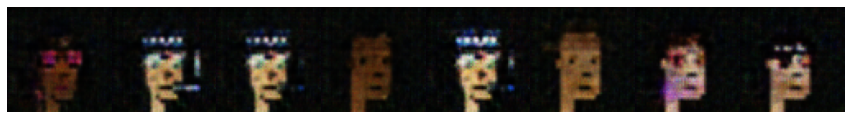

In [ ]:
#sample generation
generator.to(device)
generator.eval()       #eval mode
sample_size=8

for i in range(8):    
    
    #generate latent vectors
    fixed_z = Generator.get_noise(n_samples=sample_size, 
                                  z_dim=z_dim, 
                                  device=device)    
    
    #generate samples
    sample_image = generator(fixed_z)
    
    #display samples
    print_tensor_images(sample_image)

In [ ]:
plt.savefig()

torch.Size([8, 3, 64, 64])